##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [9]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [10]:

df = pd.read_csv("../../data/hind-copper/hind_copper.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-17,47.750000,47.750000,46.549999,46.700001,74331.0
1,2020-01-20,46.950001,46.950001,45.750000,45.849998,72887.0
2,2020-01-21,45.599998,45.700001,44.950001,45.000000,45188.0
3,2020-01-22,45.299999,45.650002,44.450001,44.599998,79445.0
4,2020-01-23,44.650002,45.650002,44.599998,45.000000,53742.0


In [11]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-05,30.000000,30.700001,29.700001,29.049999,132113.0,35.177351,31.04,33.190,34.933333,39.086667,18.550730,-2.715583,-2.420919
1,2020-03-06,29.799999,29.799999,28.299999,27.750000,209963.0,34.691091,30.41,32.620,34.173333,38.615000,20.846908,-2.798598,-2.505541
2,2020-03-09,28.450001,28.500000,26.850000,28.100000,165035.0,34.112499,29.94,31.870,33.356667,38.083333,22.145334,-2.929072,-2.598207
3,2020-03-11,27.950001,28.400000,26.900000,24.450001,108019.0,33.461585,29.49,31.165,32.673333,37.453333,25.088339,-2.971019,-2.678272
4,2020-03-12,27.000000,27.000000,23.400000,26.000000,226738.0,32.914331,28.97,30.480,32.160000,36.891667,15.178575,-3.246505,-2.798530


In [12]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,29.049999,35.177351,31.04,33.190,34.933333,39.086667,18.550730,-2.715583,-2.420919
1,27.750000,34.691091,30.41,32.620,34.173333,38.615000,20.846908,-2.798598,-2.505541
2,28.100000,34.112499,29.94,31.870,33.356667,38.083333,22.145334,-2.929072,-2.598207
3,24.450001,33.461585,29.49,31.165,32.673333,37.453333,25.088339,-2.971019,-2.678272
4,26.000000,32.914331,28.97,30.480,32.160000,36.891667,15.178575,-3.246505,-2.798530


#### Separating the data into train and test splits. Then splitting into validation split

In [13]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [15]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [16]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [17]:
EPOCHS = 400
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [18]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [19]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [20]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [21]:
loss_stats = {
    'train': [],
    "val": []
}

In [22]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  0%|          | 0/400 [00:00<?, ?it/s]

 18%|█▊        | 70/400 [00:05<00:09, 36.14it/s]

Epoch 050: | Train Loss: 124.90095 | Val Loss: 117.20298


 31%|███       | 123/400 [00:05<00:03, 81.24it/s]

Epoch 100: | Train Loss: 3.42465 | Val Loss: 4.76013


 41%|████▏     | 165/400 [00:05<00:02, 111.64it/s]

Epoch 150: | Train Loss: 0.61047 | Val Loss: 0.87076


 55%|█████▌    | 221/400 [00:06<00:01, 126.65it/s]

Epoch 200: | Train Loss: 0.18528 | Val Loss: 0.22400


 70%|██████▉   | 278/400 [00:06<00:00, 135.63it/s]

Epoch 250: | Train Loss: 0.09743 | Val Loss: 0.08709


 80%|████████  | 320/400 [00:07<00:00, 134.92it/s]

Epoch 300: | Train Loss: 0.08465 | Val Loss: 0.06788


 94%|█████████▍| 376/400 [00:07<00:00, 135.96it/s]

Epoch 350: | Train Loss: 0.07886 | Val Loss: 0.06325


100%|██████████| 400/400 [00:07<00:00, 51.96it/s] 

Epoch 400: | Train Loss: 0.07833 | Val Loss: 0.06379


In [23]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

400
400


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

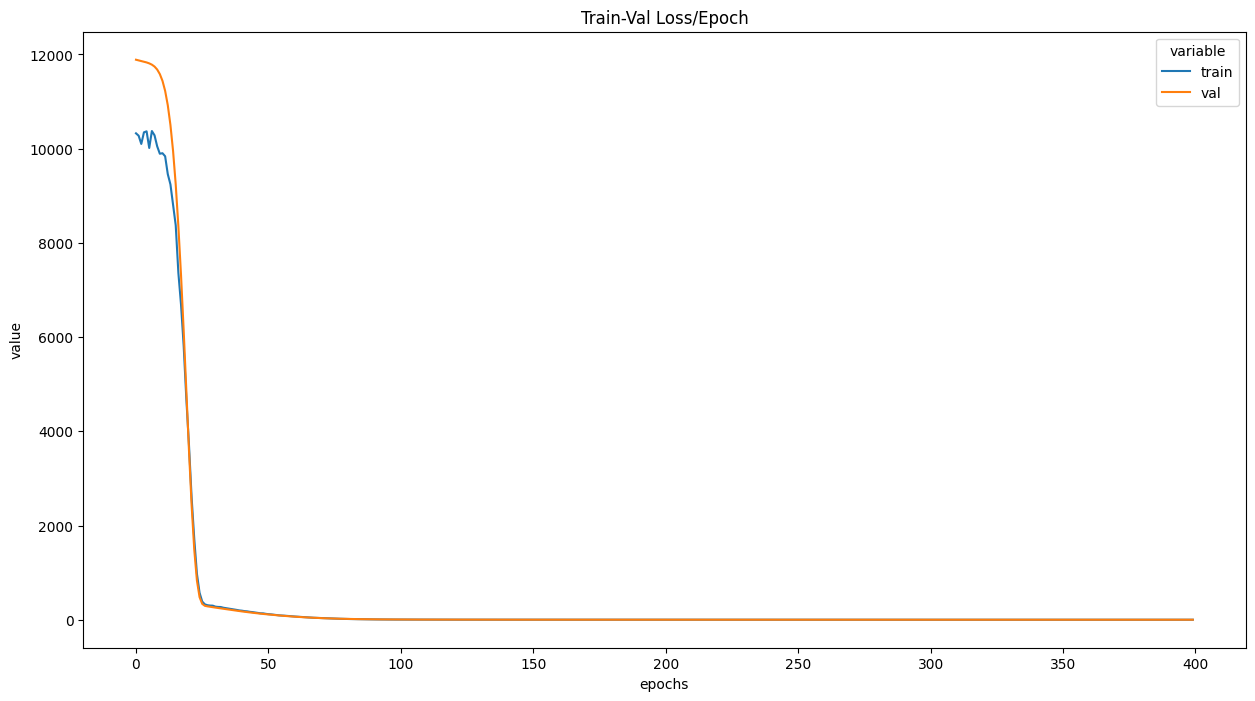

In [24]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

In [25]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())

100%|██████████| 3/3 [00:00<00:00, 21657.34it/s]

[111.39678, 111.138695, 111.01498, 111.024, 111.39494, 111.892, 112.193184, 112.232315, 112.61586, 113.317276, 113.87175, 114.65149, 115.12353, 115.254135, 115.51852, 115.7303, 115.71563, 115.56988, 115.91349, 115.76724, 115.332794, 115.15904, 114.943344, 114.36195, 113.75192, 112.37268, 111.381645, 110.99072, 110.566, 110.33041, 110.465866, 111.211, 111.657295, 111.891655, 112.373985, 112.95853, 113.51459, 114.32207, 115.305214, 116.40793, 117.724106, 118.72307, 119.576126, 120.61112, 121.70035, 122.59334, 123.13095, 123.6797, 124.00366, 123.98895, 123.62192, 123.59726, 122.96016, 122.273766, 120.82813, 119.399414, 117.874466, 116.75763, 115.59787, 114.84631, 114.097565, 113.33157, 112.55713, 112.06749, 111.69829, 111.163536, 110.522514, 109.49187, 108.65166, 107.912895, 107.03112, 105.955154, 105.65814, 105.117226, 104.896996, 104.76489, 104.54577, 104.233345, 103.80764, 103.22928, 102.69654, 102.31547, 101.683945, 101.466934, 101.07089, 101.0005, 100.77747, 100.66786, 100.156784, 99

In [26]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 0.0325090264361047
R^2 : 0.9994943508438479
Accuracy (using MSE): 99.9674909735639%
Mean absolute percentage error: 99.99873543649998%


#### Visualising the data

In [27]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as gofig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=temp.index // 15, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=(len(temp) // 15 + (temp.index // 15)),
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)

fig.add_trace(go.Scatter(x=(len(temp) // 15 + (temp.index // 15)),
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)



fig.show()
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [28]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)
fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=temp.index // 15, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=(len(temp) // 15 + (temp.index // 15)),
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)

fig.add_trace(go.Scatter(x=(len(temp) // 15 + (temp.index // 15)),
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)



fig.show()

fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()